## DATA AUGMENTATION
- Horizontal Flips
- Randomized Patching of 224 x 224 pixels
- PCA Based intensity modification 

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
# pca based RBG intensity modification as per paper
import numpy as np
import torch
from PIL import Image

set_seed(42)
def pca_clr_augmentation(img, alpha = 1):
    img = np.asarray(img)
    og_img = img.astype(float).copy()
    img = img / 255.0 # normalize it

    reshaped_img = img.reshape(-1,3) # each row = 1 rgb pixel
    cov = np.cov(reshaped_img, rowvar= False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov)

    alphas = np.random.normal(0, alpha, 3)
    new_pixels = np.dot(eigen_vectors, eigen_values*alphas)

    for i in range(3):
        og_img[..., i] += new_pixels[i]

    og_img = np.clip(og_img, 0, 255).astype('uint8')
    return Image.fromarray(og_img)

In [4]:
testimage_path = r"C:\Projects\AlexNet Implementation\insects\slug\slug (15).jpg"
testimage = Image.open(testimage_path)

In [5]:
augmented_img = pca_clr_augmentation(testimage, alpha=0.5)

In [6]:
import matplotlib.pyplot as plt

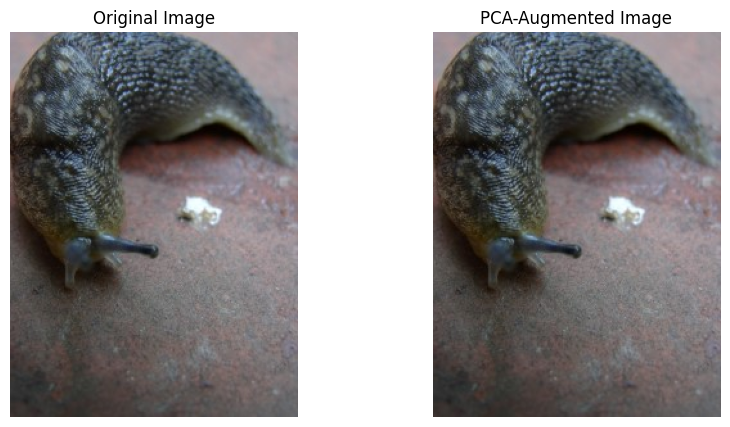

In [ ]:

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(testimage)
plt.axis("off")


plt.subplot(1, 2, 2)
plt.title("PCA-Augmented Image")
plt.imshow(augmented_img)
plt.axis("off")

plt.show()

In [8]:
set_seed(42)
data_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Lambda(lambda img: pca_clr_augmentation(img, alpha=0.5)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

## DATA LOADING AND PREP

In [9]:
dataset_path = 'binaryinsects'
dataset =  datasets.ImageFolder(root=dataset_path, transform=data_transforms)

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 934
    Root location: binaryinsects
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
dataset.classes

['catterpillar', 'snail']

In [12]:
len(dataset.classes)

2

In [13]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [14]:
set_seed(42)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [15]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [16]:
for images, labels in train_loader:
    print(labels)
    break
    

tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0])


In [17]:
v=0
for images, labels in train_loader:
    print(images.shape)
    break
    

torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


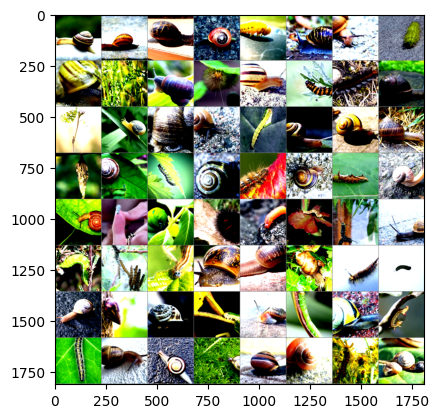

Labels: tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))  #
print('Labels:', labels)


## ALEXNET ARCHITECTURE DEFINITION

In [19]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

In [20]:
set_seed(42)
class AlexNet(nn.Module):
    def __init__(self, classes = 2):
        super(AlexNet, self).__init__()

        # layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        self.localresponsenorm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.localresponsenorm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(in_features=9216, out_features=4096) # 6 x 6 x 256 = 9216 (flatenned output of last max pool layer)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=classes)

        self.drop = nn.Dropout(p=0.7)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.localresponsenorm1(x)
        x = self.mpool1(x)
        x = F.relu(self.conv2(x))
        x = self.localresponsenorm2(x)
        x = self.mpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool3(x)

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x= self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        #x = F.softmax(x, dim=1) # commented out bcz pytorch's crossentropyloss function already takes the log probs

        return x




In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [23]:
set_seed(42)
model = AlexNet()
model.to(device)

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
    break


Output shape: torch.Size([64, 2]), Labels shape: torch.Size([64])


In [24]:
for param in model.parameters():
    print(param.device)


cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [25]:
import torch.optim as optim

In [26]:
set_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [27]:
len(train_loader)

12

In [28]:
set_seed(42)
no_of_epochs = 20
for epoch in range(no_of_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{no_of_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.6933
Epoch [2/20], Loss: 0.6931
Epoch [3/20], Loss: 0.6931
Epoch [4/20], Loss: 0.6931


KeyboardInterrupt: 

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

Accuracy on test set: 45.98930481283423%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on validation set: {accuracy:.2f}%')


Accuracy on validation set: 81.28%
